In [94]:
# 라이브러리
import random
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy.random import randint, rand
import pickle

In [95]:
# 데이터 불러오기
machine_info = pd.read_csv("./data/machine_info.csv")
order_info = pd.read_csv("./data/order_info.csv")
# order_info_nl = pd.read_csv("./data/order_info_nl.csv", header=None)
# order_info_nl_eng = pd.read_csv("./data/order_info_nl_eng.csv")

In [96]:
# 전처리 (1): column name 변경
order_info = order_info.rename(columns={
    '영업납기': 'time',
    '중산도면': 'item',
    '단가': 'cost',
    '수량': 'qty',
    '선급': 'urgent'
})

machine_info = machine_info.rename(columns={
    'JSDWG': 'item',
    'MCNO': 'machine',
    'AVG_CT': 'capacity'
})

In [97]:
# 머신인포 dropna, 4자리 숫자 문자열로 변환
machine_info.dropna(inplace=True)
machine_info['machine'] = machine_info['machine'].apply(lambda x: str(int(x)).zfill(4))

In [98]:
# 아이템 -> item01
unique_items = sorted(order_info['item'].unique(), reverse=True)

items_mapping = {
        item: f"item{str(i+1).zfill(2)}"
        for i, item in enumerate(unique_items)
    }

def change_item_name(target):
    result = str(target)
    for k, v in items_mapping.items():
        result = result.replace(k, v)

    return result

change_item_name('057791')

'item87'

In [99]:
machine_info['item'] = machine_info['item'].apply(change_item_name)
cond = machine_info['item'].isin(items_mapping.values())
machine_info[cond].head()

,item,machine,capacity
897,item96,0408,4.89
898,item96,0409,5.92
899,item96,0410,4.91
900,item96,0412,3.50
901,item96,0416,1.03


In [100]:
order_info['item'] = order_info['item'].apply(change_item_name)
order_info.head()

,time,item,cost,qty,urgent
0,2021-05-13,item15,25870,318,검사품
1,2021-05-24,item16,16229,383,검사품
2,2021-05-30,item96,8333,19,NaN
3,2021-06-03,item91,36533,4,NaN
4,2021-06-18,item87,45500,196,검사품


In [101]:
# machine -> machine01
unique_machines = sorted(machine_info['machine'].dropna().unique())

machines_mapping = {
        machine: f"machine{str(i+1).zfill(2)}"
        for i, machine in enumerate(unique_machines)
    }

def change_machine_name(target):
    result = str(target)
    for k, v in machines_mapping.items():
        result = result.replace(k, v)

    return result

change_machine_name('0421')

'machine19'

In [102]:
machine_info['machine'] = machine_info['machine'].apply(change_machine_name)
machine_info.head()

,item,machine,capacity
0,050060,machine28,1.08
1,050093,machine04,7.13
2,050093,machine08,4.67
3,050093,machine10,4.50
4,050093,machine14,3.92


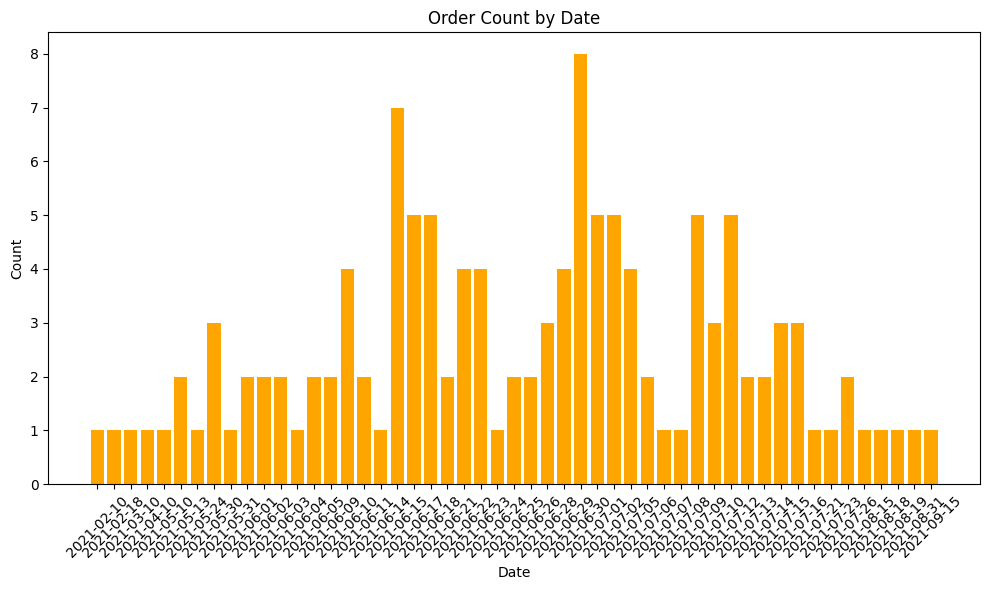

In [103]:
# 날짜별 주문 수 세기
cond = order_info['time']
order_counts = order_info['time'].value_counts().sort_index()

# barplot 그리기
plt.figure(figsize=(10, 6))
plt.bar(order_counts.index, order_counts.values, color='orange')
plt.xticks(rotation=45)
plt.title('Order Count by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [104]:
counts_array = order_counts.values
# 방법 1: Pandas로 value_counts
count_series = pd.Series(counts_array)
print(count_series.value_counts().sort_index())

1    19
2    14
3     5
4     5
5     6
7     1
8     1
Name: count, dtype: int64


In [105]:
# 값과 해당 값의 등장 횟수 (즉, 분포)
values = np.array([1, 2, 3, 4, 5, 6, 7, 8])
counts = np.array([19, 14, 5, 5, 6, 1, 1, 1])

# 확률 분포로 변환
prob = counts / counts.sum()

# 랜덤 샘플링 (예: 10개 뽑기)
samples = np.random.choice(values, size=10, p=prob)
print(samples)

[1 3 3 8 1 2 2 2 2 2]


In [106]:
# 전처리 - order
def preprocess_order(df):
    # 긴급 생산 요건이 있는 경우 1, 그렇지 않은 경우는 0
    df['urgent'] = df['urgent'].fillna(0)

    for i in range(len(df)):
        if df.loc[i, 'urgent'] != 0:
            df.loc[i, 'urgent'] = 1

    df.dropna(axis=0, inplace=True)

    # 같은 종류의 order 묶기
    df = df.groupby(['time','item','cost','urgent']).sum().reset_index()
    
    return df

# 전처리 - machine
def preprocess_machine(df):
    df.dropna(axis=0, inplace=True)

    return df

In [107]:
augmented_order_info = order_info.copy()
augmented_order_info.head(2)

,time,item,cost,qty,urgent
0,2021-05-13,item15,25870,318,검사품
1,2021-05-24,item16,16229,383,검사품


In [108]:
# Augmentation Method 1 - time 제외한 나머지 shuffle
# 가장 쉬운 augmented 방법
# time열 고정, [['item', 'cost', 'qty', 'urgent']] 4개 열은 묶음으로 셔플.
# 기존 데이터의 분포를 거의 완벽히 따라했지만, 창의적인 데이터는 아님.

temp = augmented_order_info[['item', 'cost', 'qty', 'urgent']]
temp = temp.sample(frac=1).reset_index(drop=True)
augmented_order_info[['item', 'cost', 'qty', 'urgent']] = temp
augmented_order_info.head()

# 함수화
def augmented_simple_shuffle(df):
    df = df.copy()
    shuffle_cols = ['item', 'cost', 'qty', 'urgent']
    
    # 셔플할 부분만 뽑아서 섞은 후 재할당
    shuffled = df[shuffle_cols].sample(frac=1).reset_index(drop=True)
    df[shuffle_cols] = shuffled
    
    return df

augmented_df = augmented_simple_shuffle(augmented_order_info)
augmented_df.head()

,time,item,cost,qty,urgent
0,2021-05-13,item17,24418,40,BV/W
1,2021-05-24,item89,24418,200,BV/W
2,2021-05-30,item19,19300,2,검사품
3,2021-06-03,item29,6750,12,NaN
4,2021-06-18,item05,2990,500,NaN


In [109]:
# Augmentation Method 2 - time random
# 날짜의 다양성
# 날짜를 같은 달 중 랜덤으로 바꾸기. 2021년도만 적용

date_range_2021 = pd.date_range(start="2021-01-01", end="2021-12-31")
temp = order_info.copy()
temp['month'] = temp['time'].str[5:7]
temp = temp['month'].value_counts()
month_n_dict = temp.to_dict()
rand_date_ls = list()

for k, v in month_n_dict.items():
    cond = order_info['time'].str[5:7] == k
    temp_df = order_info[cond]
    time_unique = temp_df['time'].value_counts()
    time_unique_n_dict = time_unique.to_dict()


    filtered_dates = list([date.strftime('%Y-%m-%d')
                            for date in date_range_2021 if date.strftime('%m') == k])
   
    rand_date_unique = np.random.choice(filtered_dates, size=len(time_unique_n_dict))
    
    for rand_k, [existing_k, existing_v] in zip(rand_date_unique, time_unique_n_dict.items()):
        temp_ls = [str(rand_k) for _ in range(existing_v)]
        rand_date_ls.extend(temp_ls)

print(len(rand_date_ls), rand_date_ls)
    
augmented_order_info_df = order_info.copy()
augmented_order_info_df['time'] = sorted(rand_date_ls)
augmented_order_info_df.head(10)

# 함수화
def augmented_random_time(df):
    df = df.copy()
    date_range_2021 = pd.date_range(start="2021-01-01", end="2021-12-31")
    
    # 월별 count
    df['month'] = df['time'].str[5:7]
    month_n_dict = df['month'].value_counts().to_dict()
    rand_date_ls = []

    for k, v in month_n_dict.items():
        cond = df['time'].str[5:7] == k
        temp_df = df[cond]
        time_unique = temp_df['time'].value_counts()
        time_unique_n_dict = time_unique.to_dict()

        filtered_dates = [date.strftime('%Y-%m-%d')
                          for date in date_range_2021 if date.strftime('%m') == k]
        
        rand_date_unique = np.random.choice(filtered_dates, size=len(time_unique_n_dict), replace=True)

        for rand_k, (existing_k, existing_v) in zip(rand_date_unique, time_unique_n_dict.items()):
            rand_date_ls.extend([str(rand_k)] * existing_v)

    # 새로 생성된 time 리스트를 정렬된 순서로 할당
    df['time'] = sorted(rand_date_ls)
    df.drop(columns=['month'], inplace=True)

    return df

augmented_df = augmented_random_time(order_info)
augmented_df.head()


127 ['2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-12', '2021-06-12', '2021-06-12', '2021-06-12', '2021-06-12', '2021-06-12', '2021-06-12', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-14', '2021-06-10', '2021-06-10', '2021-06-10', '2021-06-10', '2021-06-10', '2021-06-25', '2021-06-25', '2021-06-25', '2021-06-25', '2021-06-27', '2021-06-27', '2021-06-27', '2021-06-27', '2021-06-23', '2021-06-23', '2021-06-23', '2021-06-23', '2021-06-20', '2021-06-20', '2021-06-20', '2021-06-20', '2021-06-07', '2021-06-07', '2021-06-07', '2021-06-13', '2021-06-13', '2021-06-07', '2021-06-07', '2021-06-29', '2021-06-29', '2021-06-04', '2021-06-04', '2021-06-03', '2021-06-03', '2021-06-17', '2021-06-17', '2021-06-30', '2021-06-30', '2021-06-14', '2021-06-14', '2021-06-29', '2021-06-29', '2021-06-26', '2021-06-30', '2021-06-21', '2021-07-10', '2021-07-10', '2021-07-10', '2021-07-10', '2021-07-10', '2021-07-29', '

,time,item,cost,qty,urgent
0,2021-02-02,item15,25870,318,검사품
1,2021-02-09,item16,16229,383,검사품
2,2021-03-29,item96,8333,19,NaN
3,2021-04-06,item91,36533,4,NaN
4,2021-05-06,item87,45500,196,검사품


In [110]:
# Augmentation Method 3 - urgent random
# urgent 열 단순 셔플플
temp = order_info['urgent'].sample(frac=1).reset_index(drop=True)
augmented_order_info_df = order_info.copy()
augmented_order_info_df['urgent'] = temp
augmented_order_info_df.head(10)

# 함수화
def augmented_urgent_shuffle(df):
    df = df.copy()
    df['urgent'] = df['urgent'].sample(frac=1).reset_index(drop=True)
    return df

augmented_df = augmented_urgent_shuffle(order_info)
augmented_df.head()

,time,item,cost,qty,urgent
0,2021-05-13,item15,25870,318,ABS/W
1,2021-05-24,item16,16229,383,검사품
2,2021-05-30,item96,8333,19,검사품
3,2021-06-03,item91,36533,4,NaN
4,2021-06-18,item87,45500,196,NaN


In [111]:
# Augmentation Method 4 - qty random
# 아이템별 min, max 구하여 uniform 랜덤값 적용

# 아이템번호 : [min_q, max_q]
item_unique = order_info['item'].unique()
item_qty_minmax_dict = dict() # 아이템 번호
for item in item_unique:
    cond = order_info['item'] == item
    temp = order_info[cond]
    item_min, item_max = int(temp['qty'].min()), int(temp['qty'].max())
    item_qty_minmax_dict[item] = [item_min, item_max]

augmented_order_info_df = order_info.copy()
for idx, row in augmented_order_info_df.iterrows():
    item_name = row['item']
    low, high = item_qty_minmax_dict[item_name]
    rand_int = int(np.random.uniform(low=low, high=high, size=1)[0])
    augmented_order_info_df.loc['idx', 'qty'] = rand_int
    augmented_order_info_df['qty'].astype('int')

augmented_order_info_df.head(20)

# 함수화
def augmented_random_qty(df):
    df = df.copy()
    
    # 각 아이템에 대해 qty의 min-max 계산
    item_qty_minmax_dict = {
        item: [int(group['qty'].min()), int(group['qty'].max())]
        for item, group in df.groupby('item')
    }

    # 랜덤 qty로 대체
    new_qty = []
    for _, row in df.iterrows():
        item_name = row['item']
        low, high = item_qty_minmax_dict[item_name]
        rand_int = int(np.random.uniform(low=low, high=high, size=1)[0])
        new_qty.append(rand_int)

    df['qty'] = new_qty
    return df

augmented_df = augmented_random_qty(order_info)
augmented_df.head()


,time,item,cost,qty,urgent
0,2021-05-13,item15,25870,318,검사품
1,2021-05-24,item16,16229,383,검사품
2,2021-05-30,item96,8333,19,NaN
3,2021-06-03,item91,36533,4,NaN
4,2021-06-18,item87,45500,214,검사품


In [112]:
# 최종 augmentation 함수
def augment_df(
    df,
    apply_shuffle_group=True,
    apply_random_time=True,
    apply_shuffle_urgent=True,
    apply_random_qty=True
):
    """
    선택한 증강 기법들을 순차적으로 호출하여 DataFrame을 증강합니다.
    """
    df_aug = df.copy()

    if apply_shuffle_group:
        df_aug = augmented_simple_shuffle(df_aug)

    if apply_random_time:
        df_aug = augmented_random_time(df_aug)

    if apply_shuffle_urgent:
        df_aug = augmented_urgent_shuffle(df_aug)

    if apply_random_qty:
        df_aug = augmented_random_qty(df_aug)

    df_aug = df_aug.sort_values(['time', 'item', 'qty'])

    return df_aug

augmented_df = augment_df(
    order_info,
    apply_shuffle_group=True,
    apply_random_time=True,
    apply_shuffle_urgent=True,
    apply_random_qty=True
)

augmented_df.head()

,time,item,cost,qty,urgent
0,2021-02-17,item31,7500,16,검사품
1,2021-02-18,item28,17050,8,NaN
2,2021-03-15,item49,11500,42,NaN
3,2021-04-14,item38,7600,70,NaN
4,2021-05-01,item90,21260,10,NaN


In [113]:
# 기존 전처리 수행

# 날짜 -> 일수(날짜 - 2021-01-01) (1~365)
def change_time_name(target):
    time = pd.to_datetime(target)
    base_date = pd.to_datetime('2021-01-01')

    return f'date{str((time-base_date).days+1).zfill(3)}'

In [114]:
# 슬라이딩 윈도우 함수 정의
def create_shifted_dataset(df, window_size=5):
    datasets = []
    for i in range(len(df) - window_size + 1):
        window = df.iloc[i:i+window_size].reset_index(drop=True)
        datasets.append(window)
    return datasets

In [115]:
def make_dataset(order_info, machine_info, window_size=5):
    dataset = create_shifted_dataset(order_info, window_size=window_size)
    dataset_for_ga = list()
    dataset_for_order = list()

    for data in dataset:
        order = data.iloc[:, :5]
        nl = data.iloc[:, 5:]

        order = preprocess_order(order)
        dataset_for_order.append(order)
        order = pd.merge(order, machine_info, on='item', how='inner')

        dataset_for_ga.append(order)

    return dataset_for_ga, dataset_for_order

In [116]:
def ga_preprocess(dataset):
    T = list(set(dataset['time']))
    I = list(set(dataset['item']))
    J = list(set(dataset['machine']))

    # cit = 날짜 t에, item i가 미생산 될 때 발생하는 비용
    cit = dict()
    for i in I:
        for t in T:
            temp_dataset = dataset[(dataset['item'] == i) & (dataset['time'] == t)]
            if len(temp_dataset) != 0:
                value = list(set(temp_dataset['cost']))[0]
                cit[i, t] = value
            else:
                cit[i, t] = 0

    # pit = 날짜 t에, item i가 긴급 생산이 필요한 경우 1, 그렇지 않으면 0
    pit = dict()
    for i in I:
        for t in T:
            temp_dataset = dataset[(dataset['item'] == i) & (dataset['time'] == t)]
            if len(temp_dataset) != 0:
                value = list(set(temp_dataset['urgent']))[0]
                pit[i, t] = value
            else:
                pit[i, t] = 0

    # dit = 날짜 t에 item i마다 생산되어야 하는 요구량
    dit = dict()
    for i in I:
        for t in T:
            temp_dataset = dataset[(dataset['item'] == i) & (dataset['time'] == t)]
            if len(temp_dataset) != 0:
                value = list(set(temp_dataset['qty']))[0]
                dit[i, t] = value
            else:
                dit[i, t] = 0

    # mijt= 날짜 t에 NC machine j가 item i를 생산할 수 있는 능력
    mijt = dict()
    for i in I:
        for j in J:
            temp_dataset = dataset[
                (dataset['item'] == i) &
                (dataset['machine'] == j)
            ]

            if len(temp_dataset) != 0:
                value = list(set(temp_dataset['capacity']))[0]
                for t in T:
                    mijt[i, j, t] = value
            else:
                for t in T:
                    mijt[i, j, t] = 0

    return T, I, J, cit, pit, dit, mijt

# 머신 j가 시간 t에 아이템 i를 만들수 없을 경우 0으로 처리하기 위함함
def decode(mijt, xijt):
    for j in J:
        for t in T:
            for i in I:
                if mijt[i, j, t] == 0:
                    xijt[i, j, t] = 0
    return xijt

# 목적함수를 최적화하기 위한 xijt 조합을 임의로 생성하는 함수
def generation_xijt():
    xijt = {}

    for i in I:
        for j in J:
            for t in T:
                if dit[i, t] > 0:
                    xijt[i, j, t] = random.uniform(0, 1)
                else:
                    xijt[i, j, t] = 0

    xijt = decode(mijt, xijt)
    return xijt

def dict2list(xijt):
    return list(xijt.values())

def list2dict(bitstring, type='xijt'):
    if type == 'xijt':
        _keys = xijt_keys
    elif type == 'mijt':
        _keys = mijt_keys

    xijt = {}
    for idx, value in enumerate(bitstring):
        xijt[_keys[idx]] = value

    return xijt

# 제약조건 확인
# 기계 하루 총 생산시간은 600분
# j기계로 600분 안에 아이템 i를 생산할 수 없다면 아이템 생산하지 않도록 하기 위함.
def constraint_check(xijt):
    for j in J:
        for t in T:
            check_value = sum(mijt[i, j, t] * round(xijt[i, j, t] * dit[i, t]) for i in I) <= 600

            if check_value is False:
                for i in I:
                    xijt[i, j, t] = 0

    return xijt

# 목적 함수
def objective(xijt):
    uit = {}
    xijt = constraint_check(xijt)

    for i in I:
        for t in T:
            u = dit[i, t] - sum(round(xijt[i, j, t] * dit[i, t]) for j in J)
            if u >= 0:
                uit[i, t] = u
            else:
                uit[i, t] = abs(u) * 10_000_000

    objective = sum(uit[i, t] * cit[i, t] * pit[i, t] for i in I for t in T)
    return objective

# Tournament selection
def selection(pop, scores, n_pop):
    # n_pop은 한 세대를 구성하는 염색체 수이며, 하이퍼파라미터 값
    k = round(n_pop * 0.5)
    selection_ix = randint(len(pop))
    
    for ix in randint(0, len(pop), k - 1):
        if scores[ix] < scores[selection_ix]:
            selection_ix = ix
            
    return pop[selection_ix]

def crossover(p1, p2, r_cross):
    p1 = dict2list(p1)
    p2 = dict2list(p2)
    c1, c2 = p1.copy(), p2.copy()

    if rand() < r_cross:
        base_bitstring = dict2list(mijt)

        # crossover (1): 유효 인덱스 추출
        valid_index = []
        for i in range(len(base_bitstring)):
            if base_bitstring[i] > 0:
                valid_index.append(i)

        n = round(r_cross * len(valid_index))
        pt_0 = random.sample(valid_index, n)
        pt_1 = list(set(valid_index) - set(pt_0))

        # crossover (2): 교차 적용
        for i in pt_0:
            c1[i] = p2[i]
            c2[i] = p1[i]

        for i in pt_1:
            c1[i] = p2[i]
            c2[i] = p1[i]

    return [c1, c2]

def mutation(bitstring, r_mut):
    for i in range(len(bitstring)):
        if rand() < r_mut:
            base_bitstring = dict2list(mijt)

            # mutation (1): 유효 인덱스 찾기
            valid_index = []
            for j in range(len(base_bitstring)):
                if base_bitstring[j] > 0:
                    valid_index.append(j)

            n = round(r_mut * len(valid_index))

            # mutation (2): 무작위 인덱스에서 값 변경
            pt_0 = random.sample(valid_index, n)
            for idx in pt_0:
                bitstring[idx] = random.uniform(0, 1)

def genetic_algorithm(bounds, n_iter, n_pop, r_cross, r_mut):
    # Utility
    log = []
    log_detail = []
    best_gen = 0

    # GA algorithm 초기화
    pop = [generation_xijt() for _ in range(n_pop)]
    best = decode(mijt, pop[0])
    best_eval = objective(best)
    print(best_eval)

    for gen in tqdm(range(n_iter)):
        # 현재 세대 해를 디코딩
        decoded = [decode(mijt, p) for p in pop]

        # 목적함수 값 계산
        scores = [objective(d) for d in decoded]

        # 가장 좋은 해 갱신
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(f'>best! {gen}, {scores[i]}')
                best_gen = gen
            else:
                # stop rule: 개선 없이 100세대 이상일 경우 중단
                if gen - best_gen > 200:
                    print('stop')
                    return [best, best_eval, log, log_detail]

        # 부모 해 집합 선택
        selected = [selection(pop, scores, n_pop) for _ in range(n_pop)]
        log_detail.append([gen, objective(selected[0])])

        # 자식 세대 생성
        children = []
        for i in range(0, n_pop, 2):
            p1, p2 = selected[i], selected[i + 1]
            for c in crossover(p1, p2, r_cross):
                mutation(c, r_mut)
                children.append(list2dict(c))

        pop = children
        log.append([gen, best_eval])

    return [best, best_eval, log, log_detail]

def set_hyper_parameters():
    # 하이퍼파라미터 설정
    hyper_parameters = pd.DataFrame({
        'index':    ['index_1', 'index_2', 'index_3', 'index_4',
                    'index_5', 'index_6', 'index_7', 'index_8'],
        'n_iter':   [500, 500, 500, 500, 500, 500, 500, 500],
        'n_pop':    [10, 20, 40, 20, 20, 20, 20, 20],
        'r_cross':  [0.4, 0.4, 0.4, 0.1, 0.2, 0.3, 0.4, 0.4],
        'r_mut':    [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.1, 0.6]
    })

    # 결과 기록용 열 추가
    hyper_parameters['objective'] = np.nan
    hyper_parameters['time'] = np.nan

    return hyper_parameters

def find_hyper_parameters(hyper_parameters):
    log_list = []

    for i in range(len(hyper_parameters)):
        parameter = hyper_parameters.iloc[i]
        index_nm = parameter['index']
        print(f'{index_nm}')

        start = datetime.datetime.now()

        # 초기 해 및 키 정의
        xijt = generation_xijt()
        global xijt_keys, mijt_keys
        xijt_keys = list(xijt.keys())
        mijt_keys = list(mijt.keys())

        # 하이퍼파라미터 설정
        n_iter = parameter['n_iter']
        n_pop = parameter['n_pop']
        r_cross = parameter['r_cross']
        r_mut = parameter['r_mut']

        # 유전 알고리즘 실행
        best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)

        # 실행 시간 및 결과 기록
        elapsed_time = datetime.datetime.now() - start
        hyper_parameters.loc[i, 'time'] = elapsed_time
        hyper_parameters.loc[i, 'objective'] = score

        log_list.append(log)

    # 결과 출력
    return hyper_parameters, log_list


In [117]:
# 유전 알고리즘
def ga_get_gt(dataset_for_ga):
    data_len = len(dataset_for_ga)
    
    for i, data in enumerate(dataset_for_ga):
        global T, I, J, cit, pit, dit, mijt
        T, I, J, cit, pit, dit, mijt = ga_preprocess(data)

        # 입력 데이터 생성
        xijt = generation_xijt()
        global xijt_keys, mijt_keys
        xijt_keys = list(xijt.keys())
        mijt_keys = list(mijt.keys())

        # 유전 알고리즘 하이퍼파라미터 설정 - index 07 적용
        n_iter = 500       # 반복할 세대 수
        n_pop = 20         # 세대당 염색체 수
        r_cross = 0.4      # 교차율
        r_mut = 0.1        # 변이율

        # 유전 알고리즘 실행
        best, score, log, log_detail = genetic_algorithm(mijt, n_iter, n_pop, r_cross, r_mut)

        best_ls.append(best)
        score_ls.append(score)
        log_ls.append(log)
        log_detail_ls.append(log_detail)

        with open('log_n5.pkl', 'wb') as f:
            pickle.dump([best_ls, score_ls, log_ls, log_detail_ls], f)
        print(f'{i+1}번째 log 저장 완료. 총 {data_len}개')

        # 해 솔루션 저장용 딕셔너리 초기화
        solution_ = dict()

        # xijt 디코딩
        xijt = decode(mijt, xijt)

        # best 해를 기반으로 해를 계산
        for i in I:
            for j in J:
                for t in T:
                    solution_[(i, j, t)] = round(best[i, j, t] * dit[i, t])

        # 딕셔너리를 DataFrame으로 변환
        sol = pd.DataFrame.from_dict(solution_, orient='index').reset_index()
        sol.columns = ['(item, machine, time)', 'qty']

        gt_ls.append(sol[sol['qty'] > 0])

        with open('gt_n5.pkl', 'wb') as f:
            pickle.dump(gt_ls, f)

        # print('{}번째 gt 저장 완료. 총 {}개'.format(i + 1, data_len))

        # print('------------------------')
        # print()
    # return gt_ls

In [118]:
# order machine join 정보 묶기
def combine_order_machine_join(data):
    combined_data = list()
    for _, row in data.iterrows():
        combined_data.append(f"• {row['time']} {row['item']} {row['cost']} {row['urgent']} {row['qty']} {row['machine']} {row['capacity']}")

    combined_data = "\n".join(combined_data)
        
    return combined_data

In [119]:
def combine_order(data):
    combined_data = list()
    for _, row in data.iterrows():
        combined_data.append(f"• {row['time']} {row['item']} {row['cost']} {row['urgent']} {row['qty']}")

    combined_data = "\n".join(combined_data)
        
    return combined_data

In [120]:
def combine_machine(data):
    combined_data = list()
    for _, row in data.iterrows():
        combined_data.append(f"• {row['item']} {row['machine']} {row['capacity']}")

    combined_data = list(set(combined_data))
    combined_data = "\n".join(combined_data)
        
    return combined_data

In [121]:
# gt 정보 텍스트화
def combine_gt(data):
    combined_data = list()
    for _, row in data.iterrows():
        combined_data.append(f"• {row['item']} {row['machine']} {row['time']} {row['qty']}")

    combined_data = "\n".join(combined_data)
        
    return combined_data

In [122]:
def make_augmented_dataset(order_info, machine_info):
    order_info['time'] = order_info['time'].apply(change_time_name)
    machine_info = preprocess_machine(machine_info)
    dataset_for_ga, dataset_for_order = make_dataset(order_info, machine_info)

    # 저장된 피클 불러오기기
    # with open('log.pkl', 'rb') as f:
    #     loaded_data = pickle.load(f)

    # best_ls, score_ls, log_ls, log_detail_ls = loaded_data

    # 데이터 설정정
    # temp = [dataset_for_ga[i] for i in range(10)]
    global best_ls, score_ls, log_ls, log_detail_ls, gt_ls
    best_ls, score_ls, log_ls, log_detail_ls, gt_ls = list(), list(), list(), list(), list()

    ga_get_gt(dataset_for_ga)

    # GT 결과값 데이테프레임화
    for idx, gt in enumerate(gt_ls):
        gt[['item', 'machine', 'time']] = pd.DataFrame(gt['(item, machine, time)'].tolist(), index=gt.index)
        gt = gt.drop(columns='(item, machine, time)')
        gt = gt[['item', 'machine', 'time', 'qty']].sort_values(['time', 'item', 'machine', 'qty'])
        gt_ls[idx] = gt

    order_machine_join = [combine_order_machine_join(data) for data in dataset_for_ga]
    order_for_dataset = [combine_order(data) for data in dataset_for_ga]
    machine_for_dataset = [combine_machine(data) for data in dataset_for_ga]
    gt_for_dataset = [combine_gt(data) for data in gt_ls]

    dataset = pd.DataFrame(columns=['order', 'machine', 'gt', 'objective'])
    dataset

    dataset['order'] = order_for_dataset
    dataset['machine'] = machine_for_dataset
    dataset['gt'] = gt_for_dataset
    dataset['objective'] = score_ls
    dataset.head()

    dataset['order_machine'] = (
        "Order information\n" + dataset['order'] + "\n\n" +
        "Machine information\n" + dataset['machine']
    )

    dataset['order_machine_gt'] = (
        "Order information\n" + dataset['order'] + "\n\n" +
        "Machine information\n" + dataset['machine'] + "\n\n" +
        "Schedule result\n" + dataset['gt']
    )

    dataset['order_machine_join'] = order_machine_join

    dataset['order_machine_join_gt'] = (
        "Order and machine information\n" + dataset['order_machine_join'] + "\n\n" +
        "Schedule result\n" + dataset['gt']
    )

    return dataset

In [123]:
augmented_dataset = make_augmented_dataset(augmented_df, machine_info)

/tmp/ipykernel_11877/1886978764.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['urgent'] = df['urgent'].fillna(0)
/tmp/ipykernel_11877/1886978764.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['urgent'] = df['urgent'].fillna(0)
/tmp/ipykernel_11877/1886978764.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['urgent']

30000


  1%|          | 3/500 [00:00<00:16, 29.81it/s]

>best! 0, 7500
>best! 1, 0


 40%|████      | 202/500 [00:06<00:09, 30.35it/s]


stop
1번째 log 저장 완료. 총 123개
0


 40%|████      | 201/500 [00:08<00:12, 23.16it/s]


stop
2번째 log 저장 완료. 총 123개
0


 40%|████      | 201/500 [00:05<00:08, 34.14it/s]


stop
3번째 log 저장 완료. 총 123개
5845280000000


  1%|          | 4/500 [00:00<00:14, 33.52it/s]

>best! 0, 5114620000000
>best! 0, 4749290000000
>best! 0, 4018630000000
>best! 0, 3653300000000
>best! 0, 3287970000000
>best! 1, 2557310000000


  3%|▎         | 16/500 [00:00<00:15, 31.85it/s]

>best! 10, 2191980000000


  5%|▍         | 24/500 [00:00<00:14, 32.21it/s]

>best! 18, 1826650000000
>best! 22, 730660000000


  7%|▋         | 36/500 [00:01<00:14, 32.20it/s]

>best! 30, 365330000000


 46%|████▌     | 231/500 [00:07<00:08, 32.70it/s]


stop
4번째 log 저장 완료. 총 123개
6210610000000


  1%|          | 3/500 [00:00<00:19, 24.87it/s]

>best! 0, 5845280000000
>best! 0, 5479950000000
>best! 0, 5114620000000
>best! 0, 3653300000000
>best! 0, 3287970000000
>best! 1, 2922640000000
>best! 2, 2557310000000
>best! 5, 1826650000000


  4%|▍         | 21/500 [00:00<00:18, 25.26it/s]

>best! 17, 1461320000000


 14%|█▍        | 72/500 [00:02<00:16, 25.47it/s]

>best! 68, 0


 54%|█████▍    | 269/500 [00:10<00:09, 25.54it/s]


stop
5번째 log 저장 완료. 총 123개
26384760000000


  1%|          | 4/500 [00:00<00:12, 39.20it/s]

>best! 0, 24179280000000
>best! 0, 21256640000000
>best! 0, 16480350000000
>best! 0, 14288370000000
>best! 0, 6941270000000
>best! 1, 5845280000000
>best! 5, 3653300366680


  4%|▎         | 18/500 [00:00<00:11, 42.12it/s]

>best! 12, 3653300000000


  6%|▌         | 28/500 [00:00<00:10, 43.86it/s]

>best! 22, 3287970000000


 10%|▉         | 48/500 [00:01<00:09, 45.30it/s]

>best! 43, 2557310366680


 19%|█▊        | 93/500 [00:02<00:08, 45.67it/s]

>best! 86, 2557310000000


 22%|██▏       | 108/500 [00:02<00:09, 41.89it/s]

>best! 103, 1461320000000


 61%|██████    | 304/500 [00:06<00:04, 45.47it/s]


stop
6번째 log 저장 완료. 총 123개
32693010000000


  1%|          | 6/500 [00:00<00:09, 51.03it/s]

>best! 0, 25118190000000
>best! 0, 22383300000000
>best! 0, 19285880000000
>best! 0, 16107120000000
>best! 0, 15213780000000
>best! 2, 12165630000000
>best! 2, 12153530000000
>best! 2, 8612240366680
>best! 10, 6498800000000


  8%|▊         | 41/500 [00:00<00:09, 50.72it/s]

>best! 32, 5644030000000


 15%|█▌        | 77/500 [00:01<00:08, 52.66it/s]

>best! 69, 4916170000000
>best! 72, 2680020000000


 55%|█████▍    | 273/500 [00:05<00:04, 51.43it/s]


stop
7번째 log 저장 완료. 총 123개
20992620000000


  1%|          | 5/500 [00:00<00:10, 46.87it/s]

>best! 0, 15984410000000
>best! 1, 14966960000000
>best! 2, 14885620000000
>best! 2, 13872370000000
>best! 2, 9717530000000
>best! 4, 8977570000000
>best! 7, 4629380000000


  9%|▉         | 47/500 [00:00<00:09, 50.06it/s]


KeyboardInterrupt: 

In [ ]:
augmented_dataset.to_csv('./augmented_dataset_n5_20250601.csv')